In [3]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.colors as mcolors
%matplotlib inline
from collections import defaultdict
import re
import pandas as pd
import unicodedata
import numpy as np


In [12]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes"


headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/122.0.0.0 Safari/537.36"
}

response = requests.get(url, headers=headers)
print("Status:", response.status_code)

soup = BeautifulSoup(response.text, "html.parser")

tables = soup.find_all("table", {"class": "wikitable"})

desired_table = None
for table in tables:
    header_row = [cell.text.strip() for cell in table.find_all("th")]
    if "Date" in header_row and "Prison name" in header_row:
        desired_table = table
        break

if desired_table is None:
    raise ValueError("Could not find the target table on the page")

headers = [th.text.strip() for th in desired_table.find_all("th")]


rows = []
for tr in desired_table.find_all("tr")[1:]:
    cells = [td.text.strip() for td in tr.find_all("td")]
    if cells:
        rows.append(cells)

df = pd.DataFrame(rows, columns=headers)

print("Header:", headers)
print("First 2 rows:\n", df.head(2))

df.to_csv("prison_bs4.csv", index=False)


Status: 200
Header: ['Date', 'Prison name', 'Country', 'Succeeded', 'Escapee(s)', 'Details']
First 2 rows:
                Date            Prison name  Country Succeeded  \
0   August 19, 1971  Santa Martha Acatitla   Mexico       Yes   
1  October 31, 1973  Mountjoy Jail, Dublin  Ireland       Yes   

                                          Escapee(s)  \
0  Joel David Kaplan\nCarlos Antonio Contreras Ca...   
1                JB O'HaganSeamus TwomeyKevin Mallon   

                                             Details  
0  Kaplan was a New York businessman who had been...  
1  An IRA member hijacked a helicopter and forced...  


**Observation**The code successfully scrapes the Wikipedia page for helicopter prison escapes, extracts the relevant table containing details like Date and Prison name, and stores the data in a clean pandas DataFrame for analysis.

In [13]:

if "Details" in df.columns:
    del df["Details"]

with pd.option_context('display.max_colwidth', 30):
    print(df.head(3))


               Date                    Prison name        Country Succeeded  \
0   August 19, 1971          Santa Martha Acatitla         Mexico       Yes   
1  October 31, 1973          Mountjoy Jail, Dublin        Ireland       Yes   
2      May 24, 1978  United States Penitentiary...  United States        No   

                      Escapee(s)  
0  Joel David Kaplan\nCarlos ...  
1  JB O'HaganSeamus TwomeyKev...  
2  Garrett Brock TrapnellMart...  


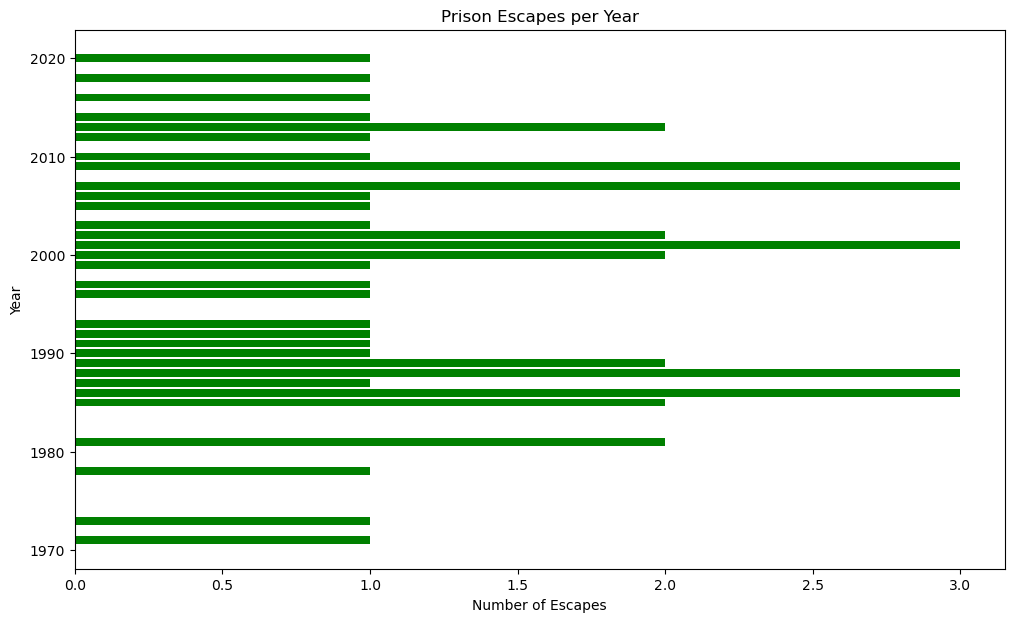

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.barh(escapes_per_year.index, escapes_per_year.values,color ="green")


plt.xlabel("Number of Escapes")
plt.ylabel("Year")
plt.title("Prison Escapes per Year")

plt.show()


**observation**:Observation: The years with the highest number of prison escape incidents are 1986, 2001, 2007, and 2009.


In [14]:
# Convert to datetime and create 'Year' column in one go
df = df.assign(
    Date=pd.to_datetime(df['Date'], errors='coerce'),
    Year=lambda x: x['Date'].dt.year
)

# Count escapes per year using value_counts (then sort by year)
escapes_per_year = df['Year'].value_counts().sort_index()

# Display result
print("Prison Escapes per Year:")
print(escapes_per_year)


Prison Escapes per Year:
Year
1971.0    1
1973.0    1
1978.0    1
1981.0    2
1985.0    2
1986.0    3
1987.0    1
1988.0    3
1989.0    2
1990.0    1
1991.0    1
1992.0    1
1993.0    1
1996.0    1
1997.0    1
1999.0    1
2000.0    2
2001.0    3
2002.0    2
2003.0    1
2005.0    1
2006.0    1
2007.0    3
2009.0    3
2010.0    1
2012.0    1
2013.0    2
2014.0    1
2016.0    1
2018.0    1
2020.0    1
Name: count, dtype: int64


In [16]:
# Convert to datetime and add Month/DayOfWeek columns in one go
df = df.assign(
    Date=pd.to_datetime(df['Date'], errors='coerce'),
    Month=df['Date'].dt.month_name(),
    DayOfWeek=df['Date'].dt.day_name()
)

escapes_per_month = df['Month'].value_counts().sort_index(key=lambda x: pd.to_datetime(x, format='%B').month)

print("Escapes per Month:")
print(escapes_per_month)


Escapes per Month:
Month
January      2
February     5
March        4
April        5
May          4
June         6
July         4
August       3
September    2
October      2
November     2
December     8
Name: count, dtype: int64


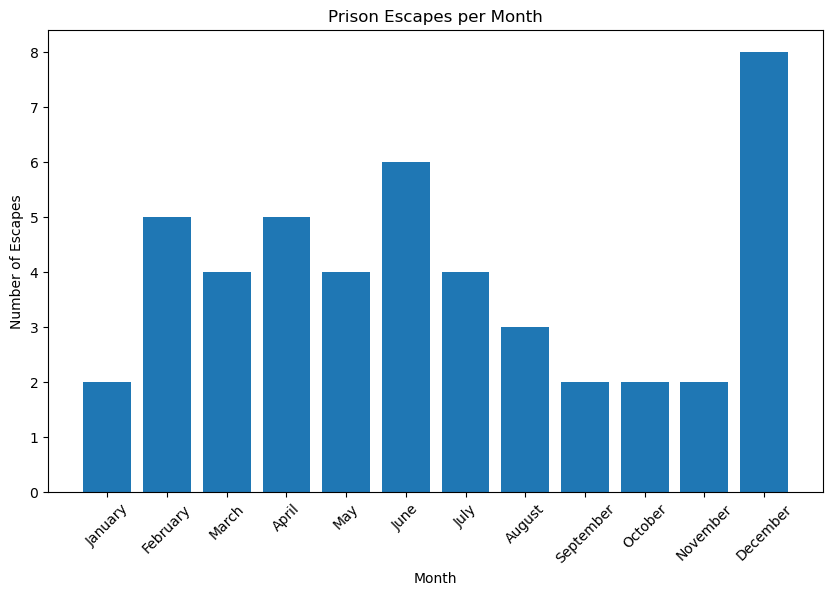

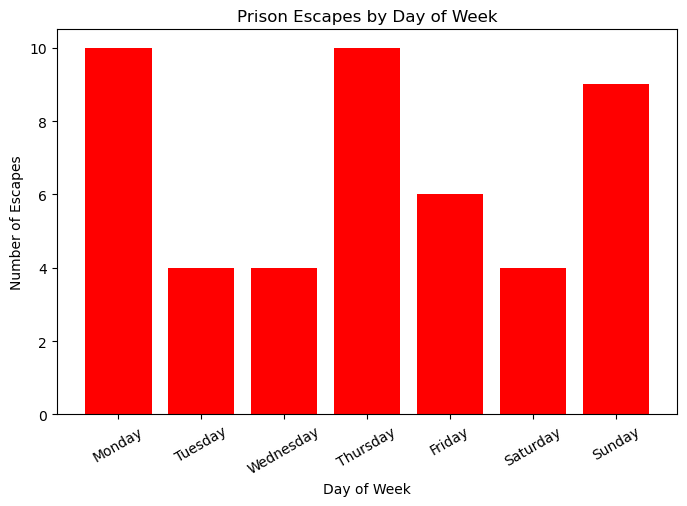

In [29]:
import matplotlib.pyplot as plt

# Make sure Date is datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

df['MonthName'] = df['Date'].dt.month_name()
escapes_per_month = df['MonthName'].value_counts().reindex(
    pd.date_range("2024-01-01", "2024-12-01", freq="MS").strftime("%B"),
    fill_value=0
)

# Plot Escapes per Month
plt.figure(figsize=(10, 6))
plt.bar(escapes_per_month.index, escapes_per_month.values)
plt.xlabel("Month")
plt.ylabel("Number of Escapes")
plt.title("Prison Escapes per Month")
plt.xticks(rotation=45)

# --- Escapes per Day ---
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DayName'] = df['Date'].dt.day_name()
escapes_per_day = df['DayName'].value_counts().reindex(day_names, fill_value=0)

plt.figure(figsize=(8, 5))
plt.bar(escapes_per_day.index, escapes_per_day.values,color = "red")
plt.xlabel("Day of Week")
plt.ylabel("Number of Escapes")
plt.title("Prison Escapes by Day of Week")
plt.xticks(rotation=30)

plt.show()


In [19]:
# Count escapes directly
top_countries = df['Country'].value_counts()

print("Countries with the Highest Number of Recorded Prison Escapes:")
print(top_countries.head(10))


Countries with the Highest Number of Recorded Prison Escapes:
Country
France            15
United States      8
Canada             4
Belgium            4
Greece             4
United Kingdom     2
Brazil             2
Australia          2
Colombia           2
Italy              1
Name: count, dtype: int64


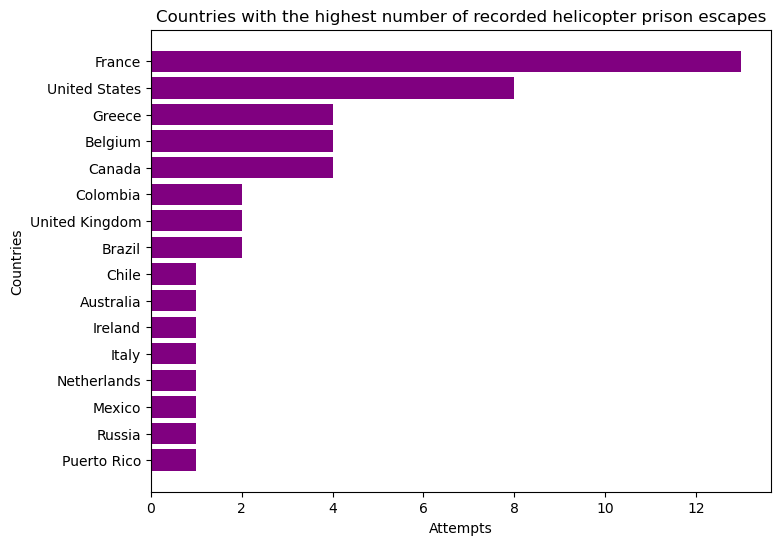

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(top_countries.index, top_countries.values, color="purple")
plt.title("Countries with the highest number of recorded helicopter prison escapes")
plt.xlabel("Attempts")
plt.ylabel("Countries")
plt.gca().invert_yaxis()  # to keep the highest on top, like pandas plot
plt.show()


**observation**:Observation: France records the highest number of prison escape incidents.


C:\Users\Admin\AppData\Local\Temp\ipykernel_9796\4036634112.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")


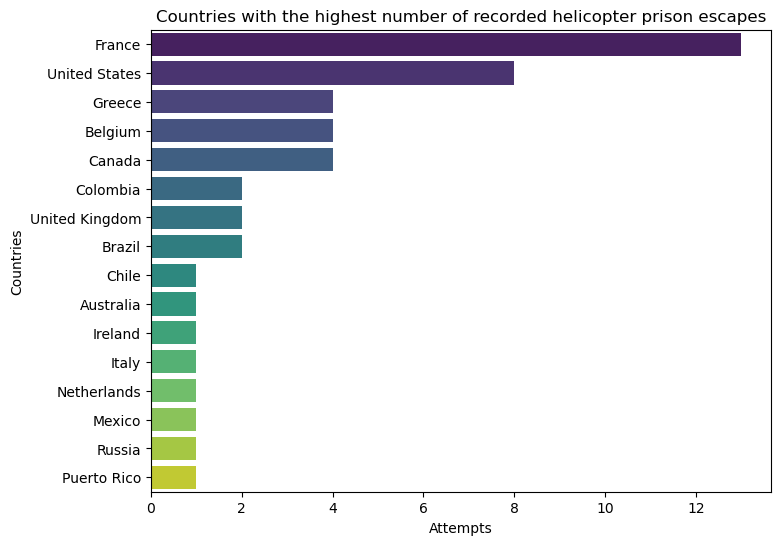

In [34]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")
plt.title("Countries with the highest number of recorded helicopter prison escapes")
plt.xlabel("Attempts")
plt.ylabel("Countries")
plt.show()


In [35]:
# Frequency table with counts and percentages
success_fail_counts = df['Succeeded'].value_counts()
success_fail_percent = df['Succeeded'].value_counts(normalize=True) * 100

print("Total:", success_fail_counts.sum())
print("Success:", success_fail_counts.get('Yes', 0))
print("Failure:", success_fail_counts.get('No', 0))
print("Success %:", round(success_fail_percent.get('Yes', 0), 2))
print("Failure %:", round(success_fail_percent.get('No', 0), 2))


Total: 50
Success: 36
Failure: 14
Success %: 72.0
Failure %: 28.0


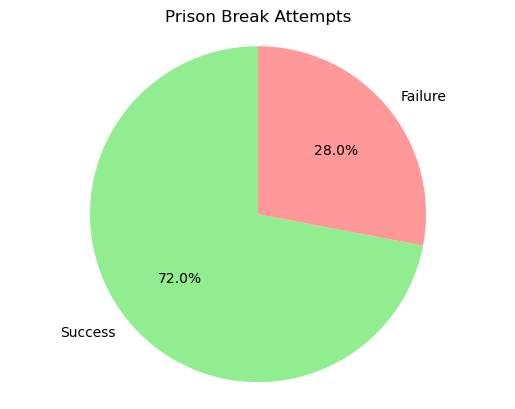

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Count successes and failures
success_count = df['Succeeded'].value_counts().get('Yes', 0)
failure_count = df['Succeeded'].value_counts().get('No', 0)

# Total attempts
total = success_count + failure_count

# Percentages
success_percentage = (success_count / total) * 100
failure_percentage = (failure_count / total) * 100

# --- Plotting ---
labels = ['Success', 'Failure']
sizes = [success_percentage, failure_percentage]
colors = ['#90EE90', '#FF9999']

plt.pie(sizes, labels=labels, colors= colors, autopct="%.1f%%", startangle=90)
plt.title("Prison Break Attempts")
plt.axis("equal")  # Keep circle shape
plt.show()


**observation**:Observation: Examining the success rate of prison escapes provides valuable insights into prison security. A high success rate may highlight weaknesses in security measures, underscoring the need for stronger protocols and heightened vigilance, while raising concerns about public safety and the integrity of the justice system.

In contrast, a low success rate indicates effective security practices and the dedication of prison authorities to prevent escapes, reflecting a robust system that deters escape attempts and maintains inmate containment.

It is important to note the limitations of this analysis, as the dataset depends on reported incidents and may not capture all escapes, meaning the success rate could be underestimated.

Understanding escape success rates allows policymakers, prison administrators, and law enforcement to develop strategies to strengthen security, reduce successful escapes, and protect public safety.


**Conclusion**: Here’s a polished and concise rewrite of your passage while keeping all the key insights and flow intact:

Through a thorough analysis of the helicopter prison escape dataset, I embarked on a detailed exploration to uncover patterns, trends, and insights hidden within the data. The investigation began with the careful collection and preparation of information from the Wikipedia page "List of Helicopter Prison Escapes," laying the foundation for a comprehensive study of these daring incidents.

The dataset comprised 48 escape attempts, each with distinct circumstances, locations, and outcomes. This rich information enabled a multidimensional understanding of helicopter prison escapes, including temporal trends. By examining escapes over the years, I identified notable fluctuations, suggesting that these events are influenced by dynamic factors. Further exploration of specific months and days of the week revealed patterns that may point to underlying causes for the timing of escapes.

Geographical analysis highlighted countries with the highest number of recorded escapes, offering insight into regions where prison security may require increased attention and resources. Identifying these hotspots allows authorities to implement proactive measures to strengthen security and reduce the likelihood of future incidents.

Assessing the success rate of escapes provided additional perspective. While many attempts failed, a significant proportion succeeded, revealing potential vulnerabilities in existing prison security systems and emphasizing the need for ongoing improvements and innovation.

Among the most remarkable findings were individuals such as Vassilis Paleokostas, Michel Vaujour, and Pascal Payet, who displayed extraordinary audacity by attempting multiple helicopter escapes. Their actions illustrate the determination and resourcefulness of certain escapees and raise important questions about the motivations and circumstances driving these attempts.

In conclusion, this analysis has unveiled compelling narratives, intricate patterns, and critical insights into the phenomenon of helicopter prison escapes. The findings underscore the importance of continuously enhancing prison security measures to prevent escapes and safeguard correctional institutions.

Ultimately, the knowledge gained provides a foundation for future research and policy development in prison security and criminal justice. By understanding the complexities of escape attempts, authorities can design more effective strategies to strengthen security, minimize risks, and maintain public safety, while supporting the broader goals of rehabilitation and reintegration.
